In [1]:
import numpy as np
from numpy.linalg import inv, multi_dot
from numpy import matmul, exp, transpose, multiply
import pandas as pd
from matplotlib import pyplot as plt
from typing import List
from scipy.optimize import minimize

In [76]:
class timeSeries():
    def __init__(self, df: pd.DataFrame, country: str, start: str, end: str):
        self.country = country
        df.loc[:,'dateRep'] = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.allCountries = df.countriesAndTerritories.unique()
        self.processedData = self.extract_country_and_time(start, end)

    def extract_country_and_time(self, start: str, end: str) -> pd.DataFrame:
        """
        Filters the data frame by the specified time frame and countries.
        Args:
            df_path (str): default = path
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd 
        """
        df = self.rawData.copy(deep = False)
        df = df[df.countriesAndTerritories == self.country]
        df = df[["dateRep", "day", "month", "year", "cases"]]
        df = df.sort_values(["year", "month","day"])

        if (start == "start") & (end == "end"):
            output_df = df
        elif (start == "start"):
            output_df = df[df.dateRep <= end]
        elif (end == "end"):
            output_df = df[df.dateRep >= start]
        else:
            output_df = df[(start <= df.dateRep) & (df.dateRep <= end)]
        
        output_df = output_df.set_index('dateRep')
        idx = pd.date_range(self.start, self.end)
        output_df = output_df.reindex(idx, fill_value=np.nan)
        output_df.loc[:,"t"] = list(range(len(output_df)))
        output_df.loc[:,"cumCases"] = output_df.loc[:,"cases"].cumsum(axis=0)
        output_df.loc[:,"cumCases"] = output_df.loc[:,"cumCases"].interpolate(method="linear")

        print(output_df)
        return output_df

    def linear_regression(self):
        """
        Returns beta of the linear regression
        and plots the prediction vs real data
        """
        df = self.processedData.copy(deep=False)
        M = len(df)
        I_0 = np.double(df.loc[df["t"] == 0, "cumCases"])
        t = np.array(df.loc[df["t"] > 0, "t"]).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"]).reshape(-1, 1)

        # Lineares Ausgleichsproblem
        X = t
        XT = t.transpose()
        y = np.log(I) - np.log(I_0)
        beta_hat = np.double(multi_dot([inv(matmul(XT, X)),XT,y])).round(4)
        prediction = I_0 * exp(beta_hat * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)
        country = self.country
        ax.set_title(f"{country}, {self.start} - {self.end}", fontsize = 18)
        ax.plot(df.t[1:],prediction, label="LAP", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Echte Daten", color="blue",marker=".")
        ax.text(0.65, 0.8, f"$\hat \\beta = $ {str(beta_hat)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show() 
        return beta_hat
    
    def nonlinear_regression(self):
        """
        Returns the result for Newton's method
        and plots the prediction vs real data
        """
        df = self.processedData
        M = len(df)
        I_0 = np.double(df.loc[df["t"] == 0, "cumCases"])
        t = np.array(df.loc[df["t"] > 0, "t"]).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"]).reshape(-1, 1)

        # Newton's Method
        def G(x):
            return matmul(transpose(I - I_0*exp(x*t)), I - I_0*exp(x*t))

        # G'(x)
        def dGdx(x):
            return 2* (I_0**2) *np.sum(np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t))))

        country = self.country
        beta_star = float(minimize(G, x0=self.linear_regression(), method="Newton-CG", jac=dGdx).x)
        prediction = I_0 * exp(beta_star * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{country}, {self.start} - {self.end}", fontsize = 18)
        ax.plot(df.t[1:],prediction, label="Newton-Methode", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Echte Daten", color="blue",marker="-")
        ax.text(0.65, 0.8, f"$ \\beta^* = $ {str(beta_star)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show()
        return beta_star
        

In [72]:
idx = pd.date_range('2020-02', '2020-03-15')
ts.processedData.to_csv('processed_data/germany.csv')

             day  month    year   cases   t     cumCases
2020-02-01   1.0    2.0  2020.0     1.0   0     1.000000
2020-02-02   NaN    NaN     NaN     NaN   1     1.500000
2020-02-03   3.0    2.0  2020.0     1.0   2     2.000000
2020-02-04   4.0    2.0  2020.0     4.0   3     6.000000
2020-02-05   5.0    2.0  2020.0     2.0   4     8.000000
2020-02-06   6.0    2.0  2020.0     1.0   5     9.000000
2020-02-07   7.0    2.0  2020.0     1.0   6    10.000000
2020-02-08   NaN    NaN     NaN     NaN   7    10.333333
2020-02-09   NaN    NaN     NaN     NaN   8    10.666667
2020-02-10  10.0    2.0  2020.0     1.0   9    11.000000
2020-02-11  11.0    2.0  2020.0     3.0  10    14.000000
2020-02-12  12.0    2.0  2020.0     1.0  11    15.000000
2020-02-13   NaN    NaN     NaN     NaN  12    15.333333
2020-02-14   NaN    NaN     NaN     NaN  13    15.666667
2020-02-15  15.0    2.0  2020.0     1.0  14    16.000000
2020-02-16   NaN    NaN     NaN     NaN  15    16.500000
2020-02-17  17.0    2.0  2020.0

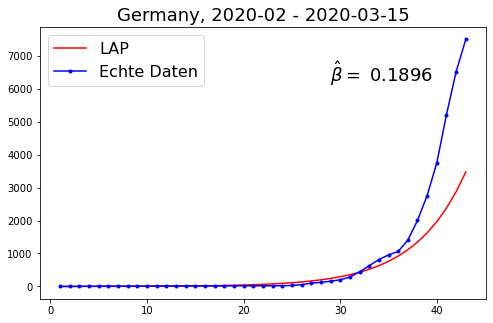

0.1896

In [77]:
df = pd.read_csv("data/europe_timeseries.csv")
ts = timeSeries(df, "Germany", "2020-02", "2020-03-15")
ts.linear_regression()

In [67]:
np.linspace(3,3,3)

array([3., 3., 3.])

In [15]:
def dGdx(x):
    I_0 = 10
    t = np.linspace(1,2,2)
    I = np.linspace(1,2,2)
    return 2* (I_0**2) *np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t)))

In [16]:
dGdx(10)

array([9.70325986e+10, 9.41541067e+19])